# Personalized Medicine: By Ashok Kumar

Let's get an understanding of the data.  
Each row of our data corresponds to a genetic mutation.  

## What is our target variable

Here, we have to classify the **Genetic mutations** into **9 classes**.  
So, this is a **classification problem**.  

## Creating Train and Test data

Each **train** and **test** Data are divided into two parts **Text** and **variants** with a common **ID** column.  
We have to merge those two data sets using **ID** column to create **Train** and **Test** data.  

## 1. Lets begin with loading the required libraries and loading our data

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
#os.chdir('/home/ashok/Documents/Personalized Medicine: Redefining Cancer Treatment')
os.getcwd()

'/gpfs/global_fs01/sym_shared/YPProdSpark/user/se05-b574f15314feea-32f81314edb4/notebook/work'

In [3]:
for i in glob.glob('*'):
    print(i)

core.38069
insta_result.csv
core.18085
core.16449
final_result.txt
final_result


In [4]:
train_text = pd.read_csv('training_text', sep = '\|\|', engine = 'python', skiprows = 1, names = ['ID','Text'])

In [5]:
train_variants = pd.read_csv('training_variants', delimiter = ',')

In [6]:
test_text = pd.read_csv('test_text', sep = '\|\|', engine = 'python', skiprows = 1, names = ['ID','Text'])

In [7]:
test_variants = pd.read_csv('test_variants', delimiter = ',')

In [8]:
print '____Dimensions of our Data Sets____'
print 'train_text'.ljust(15), train_text.shape
print 'train_variants'.ljust(15), train_variants.shape
print 'test_text'.ljust(15), test_text.shape
print 'test_variants'.ljust(15), test_variants.shape

____Dimensions of our Data Sets____
train_text      (3321, 2)
train_variants  (3321, 4)
test_text       (5668, 2)
test_variants   (5668, 3)


### Merging the text and variants data and creating Train and Test data sets:

In [9]:
train = train_text.merge(train_variants, on = 'ID', how = 'inner')
del (train_text, train_variants)

In [10]:
test = test_text.merge(test_variants, on = 'ID', how = 'inner')
del (test_text, test_variants)

In [11]:
print('Data types of train')
train.dtypes

Data types of train


ID            int64
Text         object
Gene         object
Variation    object
Class         int64
dtype: object

In [12]:
train['Class'] = train['Class'].astype('object')

In [13]:
print('Data types of test')
test.dtypes

Data types of test


ID            int64
Text         object
Gene         object
Variation    object
dtype: object

In [14]:
train.head()

,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [15]:
test.head()

,ID,Text,Gene,Variation
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A


## 2. Missing value analysis

In [16]:
train.replace([np.inf, -np.inf], np.nan, inplace = True)
test.replace([np.inf, -np.inf], np.nan, inplace = True)

In [17]:
train.isnull().sum()

ID           0
Text         0
Gene         0
Variation    0
Class        0
dtype: int64

In [18]:
test.isnull().sum()

ID           0
Text         0
Gene         0
Variation    0
dtype: int64

So, there are no missing values in our data.

## Combining Test and Train

In [19]:
data = train.append(test)

In [20]:
data = data[['ID','Text','Gene','Variation','Class']]

In [21]:
del (train,test)

In [22]:
data.head()

,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [23]:
data.shape

(8989, 5)

## 3. Preprocessing the Text data

### Decoding data from utf8 to ascii

In [24]:
def decode(text):
    text = text.encode('ascii','ignore')
    return text
data['Text'] = np.vectorize(decode)(data['Text'])

### Escaping HTML characters

First let us check if there are HTML enties in the data

In [25]:
'&amp;' in ' '.join(data.Text)

True

Now that our **Text data** contains **HTML entities**, we have to convert those entities into standard HTML tags using **HTMLParser library**.

In [26]:
import HTMLParser
HTML_parser = HTMLParser.HTMLParser()

In [27]:
def removeHTML(text):
    return HTML_parser.unescape(text)
data['Text'] = np.vectorize(removeHTML)(data['Text'])

### Removing numbers from text

In [28]:
def remove_num(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text
data['Text'] = np.vectorize(remove_num)(data['Text'])

### Removing Stop Words

In [29]:
from nltk.corpus import stopwords

In [30]:
stop_words = set(stopwords.words('english'))

In [31]:
def remove_stopwords(text):
    word_list = text.split()
    word_list = [word for word in word_list if word not in stop_words]
    text = ' '.join(word_list)
    return text
data['Text'] = np.vectorize(remove_stopwords)(data['Text'])

### Removing punctuation marks

In [32]:
from string import punctuation

In [33]:
def remove_punct(text):
    text = ' '.join(word.strip(punctuation) for word in text.split() if word.strip(punctuation))
    return text
data['Text'] = np.vectorize(remove_punct)(data['Text'])

In [34]:
def remove_u(text):
    text = text.replace('_','')
    return text
data['Text'] = np.vectorize(remove_u)(data['Text'])

In [35]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Standardising words
Eg: 'happpppy' will convert into 'happy'

In [36]:
import itertools

In [37]:
def remove_iter(text):
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    return text
data['Text'] = np.vectorize(remove_iter)(data['Text'])

### remove extra space between words

In [38]:
def remove_extra_space(text):
    word_list = text.split()
    text = ' '.join(word_list)
    return text
data['Text'] = np.vectorize(remove_extra_space)(data['Text'])

## 4. Visualisation

In [39]:
data.iloc[:3321,:].Class.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

### Visualizing how many times each class appear in Train data

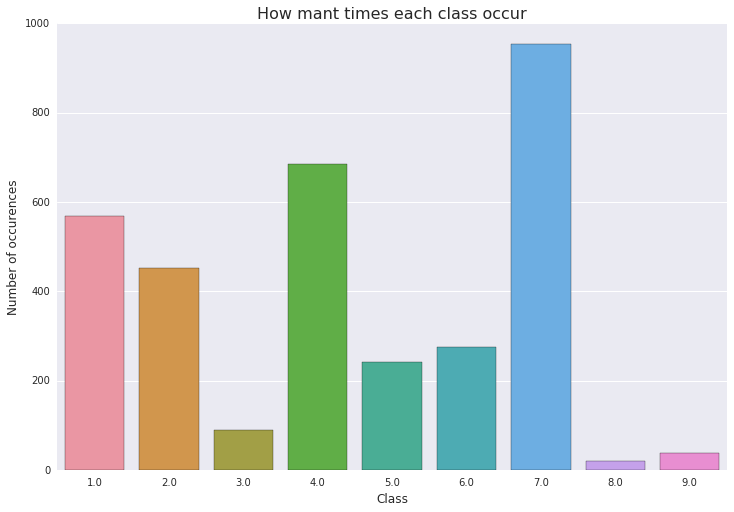

In [40]:
class_freq = data.iloc[:3321,:].Class.value_counts().reset_index()
plt.figure(figsize = (12,8))
sns.barplot(class_freq['index'],class_freq['Class'])
plt.xlabel('Class', fontsize = 12)
plt.ylabel('Number of occurences', fontsize = 12)
plt.title('How mant times each class occur', fontsize = 16)
plt.show()
del class_freq

This shows that **4,7 classes are more observed** and **3,8,9 classes are less observed**.

### Word cloud of Gene in Train

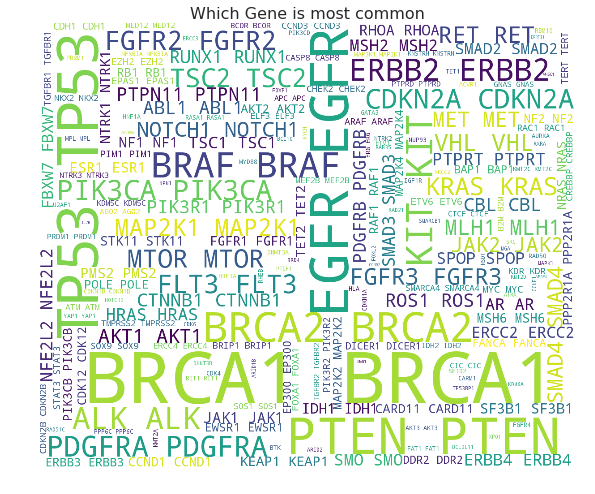

In [41]:
plt.figure(figsize = (12,8))
gene_cloud = ' '.join(data.iloc[:3321,:].Gene)
wc = WordCloud(background_color = 'white', width = 1200, height = 1000).generate(gene_cloud)
plt.imshow(wc)
plt.axis('off')
plt.title('Which Gene is most common', fontsize = 16)
plt.show()
del (gene_cloud, wc)

### Word cloud of Gene in Test

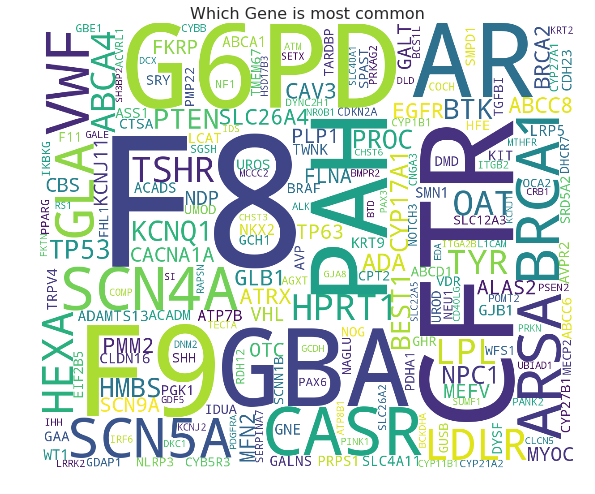

In [42]:
plt.figure(figsize = (12,8))
gene_cloud = ' '.join(data.iloc[3321:,:].Gene)
wc = WordCloud(background_color = 'white', width = 1200, height = 1000).generate(gene_cloud)
plt.imshow(wc)
plt.axis('off')
plt.title('Which Gene is most common', fontsize = 16)
plt.show()
del (gene_cloud, wc)

### Visualizing words present in train text

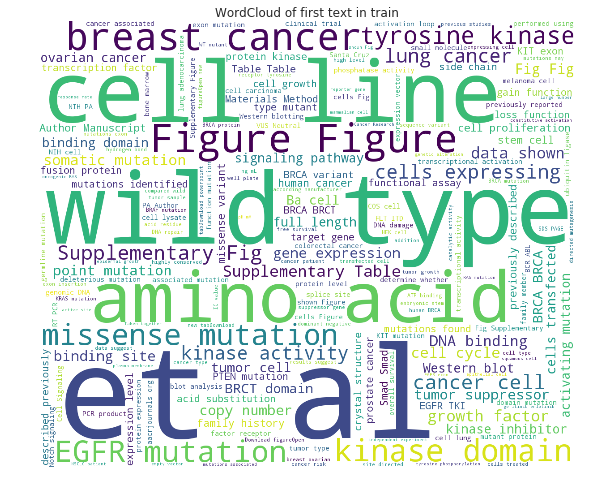

In [43]:
plt.figure(figsize = (12,8))
wc = WordCloud(background_color = 'white', width = 1200, height = 1000).generate(' '.join(data.iloc[:3321,:].Text))
plt.imshow(wc)
plt.axis('off')
plt.title('WordCloud of first text in train', fontsize = 12)
plt.show()
del wc

### Distribution of number of words present in train text

In [44]:
def word_count(text):
    return len(text.split())
train_text_count = np.vectorize(word_count)(data.iloc[:3321,:].Text)

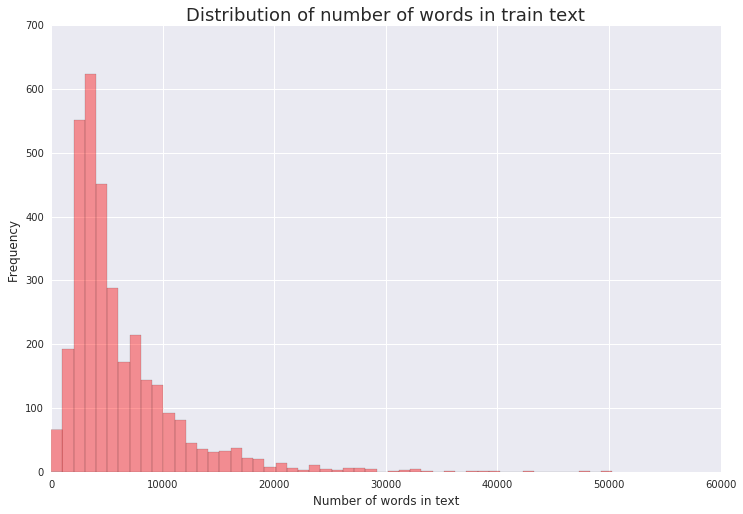

In [45]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_count, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Distribution of number of words in train text", fontsize=18)
plt.show()
del train_text_count

### Distribution of number of words present in test text

In [46]:
def word_count(text):
    return len(text.split())
test_text_count = np.vectorize(word_count)(data.iloc[3321:,:].Text)

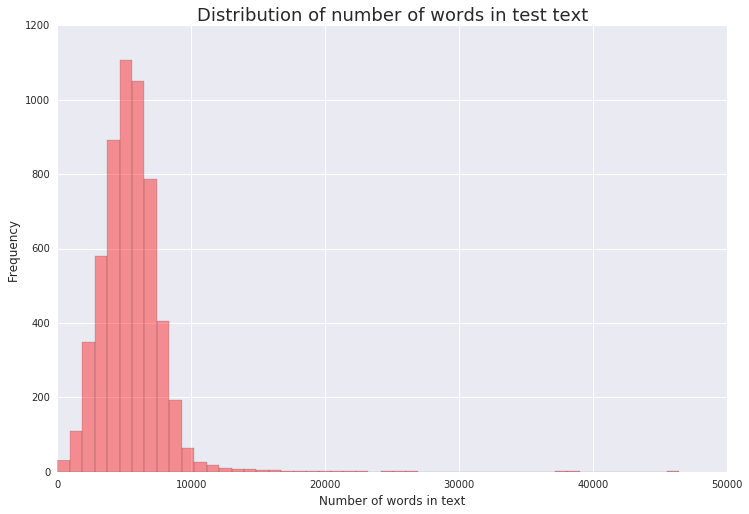

In [47]:
plt.figure(figsize=(12, 8))
sns.distplot(test_text_count, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Distribution of number of words in test text", fontsize=18)
plt.show()
del test_text_count

# 5. Term Document Matrix

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
vectorizer = CountVectorizer()
tdm = vectorizer.fit_transform(data.Text)

In [50]:
tdm_df = pd.DataFrame(tdm.toarray(), columns = vectorizer.get_feature_names())

In [51]:
#vectorizer.vocabulary_

## TF-IDF Scores

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

In [53]:
tfidf = TfidfTransformer()

In [54]:
tdm_tfidf = tfidf.fit_transform(tdm)

In [55]:
tdm_tfidf_df = pd.DataFrame(tdm_tfidf.toarray(), columns = vectorizer.get_feature_names())

## Removing Sparse terms

Removing terms that only appears in one document. Those word are not useful for classifying the text.

In [56]:
from scipy.sparse import csr_matrix

In [57]:
MIN_VAL_ALLOWED = 1

In [58]:
z = np.squeeze(np.asarray(tdm_tfidf_df.sum(axis=0) > MIN_VAL_ALLOWED))

In [59]:
tdm_tfidf_df = tdm_tfidf_df.iloc[:,z]

In [60]:
tdm_tfidf_df.shape

(8989, 14155)

### Visualizing words present in Term Document Matrix

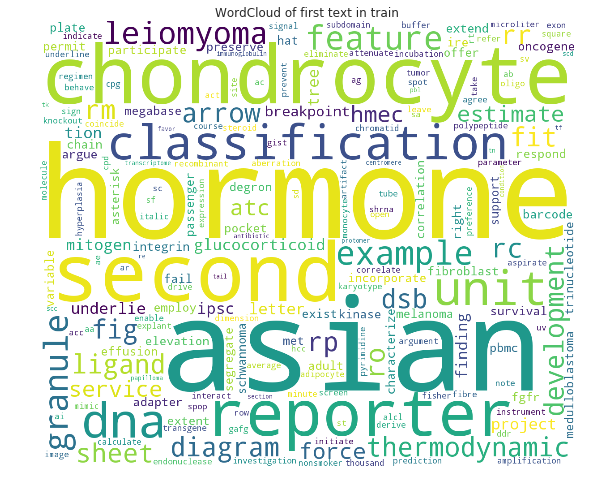

In [61]:
plt.figure(figsize = (12,8))
wc = WordCloud(background_color = 'white', width = 1200, height = 1000).generate(' '.join(list(tdm_tfidf_df.columns)))
plt.imshow(wc)
plt.axis('off')
plt.title('WordCloud of first text in train', fontsize = 12)
plt.show()
del wc

### creating Train and Test from data

In [62]:
train = data.iloc[:3321,:]

In [63]:
test = data.iloc[3321:,:]

In [64]:
train_tfidf = tdm_tfidf_df.iloc[:3321,:]

In [65]:
test_tfidf = tdm_tfidf_df.iloc[3321:,:]

In [66]:
test_tfidf = test_tfidf.reset_index(drop = True)

## 6. Feature Engineering

Creating new and usefull features from Text 

### Extracting polarity of Text 

In [67]:
def cal_sentiment(word):
    word = TextBlob(word)
    return word.sentiment.polarity
train_tfidf['polarity_text'] = np.vectorize(cal_sentiment)(train['Text'])

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
def cal_sentiment(word):
    word = TextBlob(word)
    return word.sentiment.polarity
test_tfidf['polarity_text'] = np.vectorize(cal_sentiment)(test['Text'])

### Adding Gene and Variation as numeric classes to tfidf data frames

In [69]:
train_tfidf['gene_n'] = train.Gene.astype('category').cat.codes

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [70]:
test_tfidf['gene_n'] = test.Gene.astype('category').cat.codes

In [71]:
train_tfidf['variation_n'] = train.Variation.astype('category').cat.codes

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [72]:
test_tfidf['variation_n'] = test.Variation.astype('category').cat.codes

### Number of times Gene and Variation appears in text

In [73]:
import re

In [74]:
def count_gene(text,gene):
    return len(re.findall(gene, text))
train_tfidf['gene_count'] = np.vectorize(count_gene)(train['Text'],train['Gene'])
test_tfidf['gene_count'] = np.vectorize(count_gene)(test['Text'],test['Gene'])

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [75]:
def count_variation(text,gene):
    return len(re.findall(gene, text))
train_tfidf['variation_count'] = np.vectorize(count_variation)(train['Text'],train['Variation'])
test_tfidf['variation_count'] = np.vectorize(count_variation)(test['Text'],test['Variation'])

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [76]:
train_tfidf.head()

,aa,aac,aacr,aacrjournals,aad,aag,aapc,aas,aat,ab,...,zsgreen,zstk,zurich,zygosity,zymed,polarity_text,gene_n,variation_n,gene_count,variation_count
0,0,0,0,0,0,0,0,0,0,0.004258,...,0,0,0,0.000000,0,0.040128,85,2629,0,0
1,0,0,0,0,0,0,0,0,0,0.000000,...,0,0,0,0.000000,0,0.069057,39,2856,163,0
2,0,0,0,0,0,0,0,0,0,0.000000,...,0,0,0,0.000000,0,0.069057,39,1897,163,0
3,0,0,0,0,0,0,0,0,0,0.000000,...,0,0,0,0.000000,0,0.054692,39,1667,117,0
4,0,0,0,0,0,0,0,0,0,0.004217,...,0,0,0,0.018952,0,0.049349,39,1447,197,0


In [77]:
test_tfidf.head()

,aa,aac,aacr,aacrjournals,aad,aag,aapc,aas,aat,ab,...,zsgreen,zstk,zurich,zygosity,zymed,polarity_text,gene_n,variation_n,gene_count,variation_count
0,0.000000,0.000000,0,0,0,0.000000,0,0,0.000000,0.000000,...,0,0,0,0,0.042586,0.022534,28,4217,0,0
1,0.016773,0.012769,0,0,0,0.003976,0,0,0.009333,0.000000,...,0,0,0,0,0.000000,0.034589,786,3193,0,0
2,0.002087,0.000000,0,0,0,0.000000,0,0,0.000000,0.002349,...,0,0,0,0,0.000000,0.085456,880,2492,0,0
3,0.000000,0.000000,0,0,0,0.000000,0,0,0.000000,0.000000,...,0,0,0,0,0.000000,0.032174,609,46,0,0
4,0.017193,0.000000,0,0,0,0.000000,0,0,0.000000,0.000000,...,0,0,0,0,0.000000,0.048582,1271,1802,0,0


## Creating train and test matrices

In [78]:
train_x_tfidf = train_tfidf.as_matrix(tdm_tfidf_df.columns)

In [79]:
train_y = train.as_matrix(['Class'])

In [80]:
test_x_tfidf = test_tfidf.as_matrix(tdm_tfidf_df.columns)

## 7. Preparing Model


### Using Decision Tree Classifier

In [81]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
clf = DecisionTreeClassifier()

In [83]:
clf = clf.fit(train_x_tfidf,train_y)

In [84]:
predict = clf.predict(test_x_tfidf)

In [85]:
test['Class'] = predict

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### preparing submission file

In [86]:
test.Class = test.Class.astype('int')
test.Class = test.Class.astype('object')

/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [87]:
classes = pd.get_dummies(test.Class)

In [88]:
for i in range(1,10):
    if i not in classes.columns:
        classes[str(i)] = 0

In [89]:
final_result = test.join(classes)

In [90]:
final_result = final_result[['ID',1,2,3,4,5,6,7,8,9]]
final_result = final_result.rename(columns = {1:'class1', 2:'class2', 3:'class3',
                                               4:'class4', 5:'class5', 6:'class6',
                                               7:'class7', 8:'class8', 9:'class9'})

In [91]:
for col in ['class1','class2','class3','class4','class5','class6','class7','class8','class9']:
    final_result[col] = final_result[col].astype('int')
    final_result[col] = final_result[col].astype('object')

In [92]:
final_result.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0
2,2,0,1,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0


In [93]:
final_result.shape

(5668, 10)

## Saving the final result

In [94]:
final_result.to_csv('final_result.txt', header=True, index=False, sep=',')